# **Clustering using Agglomerative algorithm**

In [0]:
import pandas as pd
import numpy as np
from scipy.spatial import distance

### **Loading Data**

In [12]:
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data["data"])
df["target"] = data.target

#### get stratified Dataset from orginal data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[df.columns.difference(['target'])], df["target"], stratify=df["target"], \
                                                    test_size=90, random_state=28)
x_train.shape, x_test.shape , y_train.shape , y_test.shape
#store it in a dataframe
df = pd.DataFrame(x_train)
df.head(2)

,0,1,2,3
31,5.4,3.4,1.5,0.4
80,5.5,2.4,3.8,1.1



### **Steps for Agglomerative clustering:**

**1)** Create a hash table to store all "clusters" --> "points" (serves as reference during implementation).

**2)** Create an empty *similarity_matrix* (or) *proximity_matrix*.

**3)** Calculate intra cluster distances/proximities and store values in *similarity_matrix*.

**4)** These steps to be followed.
>> Combine any 2 close clusters into single cluster and add it to matrix.

>> Remove those 2 clusters from matrix and **Update** *similarity_matrix*.

**5)** Recompute intra cluster distances/proximities of similarity_matrix Since *similarity_matrix* is updated.

6) Repeat step 3, 4 & 5 untill we get n_clusters(input_param).


### **Implementation**

In [0]:
class Distance:
    """
    This class 'Distance' has methods, calculates distance metrics like "euclidean", "manhattan", "cosine", "minkowski"
    These methods be called by creating object like Distance().euclidean_distance(point1, point2)
    Inputs: point1, point2.
    Output: return distance b/w points.
    """
    def __init__(self):
        pass
    def euclidean_distance(self, point1, point2):
        return distance.euclidean(point1, point2)

    def manhattan_distance(self, point1, point2):
        return distance.cityblock(point1, point2)

    def cosine_distance(self, point1, point2):
        return distance.cosine(point1, point2)

    def minkowski_distance(self, point1, point2):        
        return distance.minkowski(point1, point2)


In [0]:
def intra_cluster_distance(cluster1, cluster2, linkage="ward", distance_metric="euclidean"):
    """    
    This will take two clusters as inputs and returns the distance/proximity between those clusters.
    1) cluster1 , cluster2 = list of points (i.e. lists of list)
       These are input params to br provided.
    2) distance_metric= str and default ="Euclidean"
       We can also use "euclidean", "cosine", "manhattan".
    3) linkage= str , default="ward"(nothing but sum of squared distances).
        This is used to specify the measuring criteria of intra cluster distance(i.e. distance b/w two clusters).
        we can also use "min", "max", "average", "ward"
    """
    if distance_metric=="euclidean":
        dist_obj= Distance().euclidean_distance
    elif distance_metric=="cosine":
        dist_obj= Distance().cosine_distance
    elif distance_metric=="manhattan":
        dist_obj= Distance().manhattan_distance
    elif distance_metric=="minkowski":
        dist_obj= Distance().minkowski_distance

    visited = set()
    sum=0
    mini=float("inf")
    maxi=float("-inf")        
    for point1 in cluster1:
        for point2 in cluster2:                        
            if linkage=="min":
                mini = dist_obj(point1, point2) if dist_obj(point1, point2)<mini else mini
            elif linkage=="max":
                maxi = dist_obj(point1, point2) if dist_obj(point1, point2)>maxi else maxi
            elif linkage=="average":
                sum += dist_obj(point1, point2)
            elif linkage=="ward":
                sum += pow(dist_obj(point1, point2),2)            

    if linkage=="min":
        return mini 
    elif linkage=="max":
        return maxi
    elif linkage=="average":
        return sum/(len(cluster1)*len(cluster2)) 
    elif linkage=="ward":
        return sum/(len(cluster1)*len(cluster2)) 

In [0]:
def create_similarity_matrix(df):
    """
    This is also called as proximity matrix, to store the distances between each cluster(i.e point to point).
    Since each point is considered as a cluster in Agglomerative Clustering.
    Input: DataFrame with out class labels
    returns similarity_matrix after initialisation with all 0's.
    """
    no_of_points = df.shape[0]
    columns = list(map(lambda x:"C"+str(x), range(0,no_of_points)))
    indices = list(map(lambda x:"C"+str(x), range(0,no_of_points)))
    proximity_matrix = pd.DataFrame(columns=columns, index=indices)
    proximity_matrix = proximity_matrix.fillna(0)
    return proximity_matrix

def update_similarity_matrix(proximity_matrix, hash_table, closest_clusters):
    """
    INPUT: closest_clusters=(C1, C2) stores names of 2 close clusters.

    -Combine those 2 close clusters and Add it as a new empty row,col to similarity_matrix.
    -Drop that 2 close clusters from proximity_matrix.    
    - Do the same updation process for hash_table also
    OUTPUT: Returns updated similarity_matrix & hash_table.
    """
    new_cluster_name = "C"+"".join(closest_clusters).replace("C","")
    # updating hash_table dictionary
    hash_table[new_cluster_name] = hash_table[closest_clusters[0]]+hash_table[closest_clusters[1]] 
    hash_table.pop(closest_clusters[0])
    hash_table.pop(closest_clusters[1])
    # removing row, col 
    proximity_matrix = proximity_matrix.drop(closest_clusters, axis=1) # removes cols
    proximity_matrix = proximity_matrix.drop(closest_clusters, axis=0) #removes rows
    # adding new row, new col
    proximity_matrix.loc[new_cluster_name] = [0]*proximity_matrix.shape[1]
    proximity_matrix[new_cluster_name] = 0

    return proximity_matrix, hash_table

def recompute_similarity_matrix(proximity_matrix):
    """
    Re-compute distances and fill those gaps in the updated similarity_matrix.
    """
    for col in proximity_matrix.columns:  
        for row in proximity_matrix.index:
            proximity_matrix[col][row] = intra_cluster_distance(hash_table[col], hash_table[row])
    return proximity_matrix

In [0]:
# step-1
rows_list=[]
for row in range(df.shape[0]):
    rows_list.append([tuple(df.iloc[row])]) 

hash_table = dict(zip( list(map(lambda x:"C"+str(x), range(len(df)))), \
                      rows_list))

Output format of **hash_table**:
```
All clusters stores a list of points(d-dim).
{'C0': [(5.4, 3.4, 1.5, 0.4)],
 'C1': [(5.5, 2.4, 3.8, 1.1)],
 'C2': [(7.0, 3.2, 4.7, 1.4)],
  .
  .
 'Ci': [<Xi1,Xi2,......,Xid>],
  .
  .
 'Cn': [<Xn1,Xn2,......,Xnd>]
}
```




In [0]:
# Input parameter
n_clusters=3

In [0]:
# step-2
proximity_matrix = create_similarity_matrix(df)

# Repeat 3,4,5 steps, untill step-6 satisfied.
while proximity_matrix.shape[1]>n_clusters:
    least_dist_bw_clusters = float("inf")
    closest_clusters =[]
    for col in proximity_matrix.columns:
        for row in proximity_matrix.index:
            proximity_matrix[col][row] = intra_cluster_distance(hash_table[col], hash_table[row])
            if col!=row and proximity_matrix[col][row]<least_dist_bw_clusters:
                least_dist_bw_clusters = proximity_matrix[col][row]
                closest_clusters = [col, row]
            #print(intra_cluster_distance(hash_table[col], hash_table[row]) , end="|| ")
    
    # updating similarity_matrix
    proximity_matrix, hash_table = update_similarity_matrix(proximity_matrix, hash_table, closest_clusters)
    # recomputing similarity matrix, since, new cluster is added
    proximity_matrix = recompute_similarity_matrix(proximity_matrix)
    

In [20]:
print("No of points in each cluster : ", [len(hash_table[i]) for i in hash_table])

No of points in each cluster :  [19, 24, 14]


After running the algorithm, **hash_table** looks like this.
```
Dictionary with key=clusterid & value = list of pts E clusterid

{'C114550326171821223942581013': 
 [(6.9, 3.1, 5.1, 2.3),
  (7.0, 3.2, 4.7, 1.4),
  (6.2, 2.8, 4.8, 1.8)],
 'C354147525606141523303233343637385355': 
 [(5.4, 3.9, 1.3, 0.4),
  (4.7, 3.2, 1.6, 0.2),
  (5.1, 3.7, 1.5, 0.4)],
 'C59122471928485457162029312527404344464951': 
 [(6.1, 2.8, 4.0, 1.3),
  (5.5, 2.4, 3.8, 1.1),
  (5.8, 2.6, 4.0, 1.2)]}
```



In [22]:
# This is similarity matrix, after running algorithm.
proximity_matrix

,C354147525606141523303233343637385355,C59122471928485457162029312527404344464951,C114550326171821223942581013
C354147525606141523303233343637385355,0,12,24
C59122471928485457162029312527404344464951,12,1,3
C114550326171821223942581013,24,3,1


### **Visualization - Scatter plots**
For visualization purpose, considered only two dimensions

#### **Orginal Data**

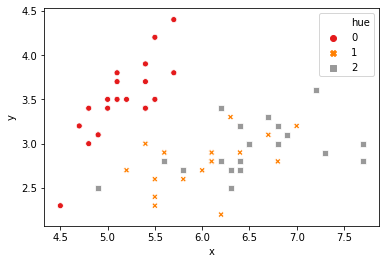

In [23]:
#@title
import matplotlib.pyplot as plt
import seaborn as sns

tdf = pd.DataFrame()
tdf["x"] = df.iloc[:,0]
tdf["y"] = df.iloc[:,1]
tdf["hue"] = y_train

ax = sns.scatterplot(x="x", y="y", hue="hue", data =tdf, style="hue", palette="Set1")
plt.show()

#### **sklearn's Agglomerative clustering**

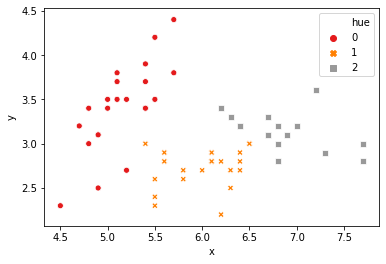

In [24]:
#@title
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3).fit(df.iloc[:,:2])
clustering.labels_

mdf = pd.DataFrame()
mdf["x"] = df.iloc[:,0]
mdf["y"] = df.iloc[:,1]
mdf["hue"] = clustering.labels_

ax = sns.scatterplot(x="x", y="y", hue="hue", data =mdf, style="hue", palette="Set1")
plt.show()

#### **Scratch Code's Agglomerative clustering**

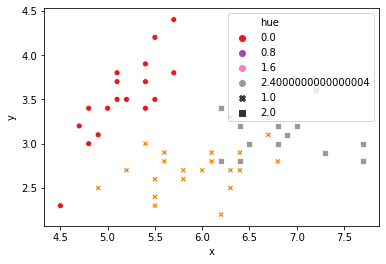

In [25]:
#@title
lst = []
cnt=0
for key in hash_table:  
  for i in hash_table[key]:
    i=list(i)
    i.append(cnt)    
    lst.append(i)
  cnt+=1
adf = pd.DataFrame(np.array(lst))
rdf= pd.DataFrame()
rdf["x"] = adf.iloc[:,0]
rdf["y"] = adf.iloc[:,1]
rdf["hue"] = adf.iloc[:,-1]

ax = sns.scatterplot(x="x", y="y", hue="hue", data =rdf, style="hue", palette="Set1")
plt.show()

